In [6]:

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows=10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("/Users/cylg/Documents/GitHub/google-crash-course/first step/data/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

def preprocess_feature(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"] /california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value"]= (california_housing_dataframe["median_house_value"]/1000.0)
    return output_targets

training_examples = preprocess_feature(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_feature(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]
correlation_dataframe.corr()

def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

def my_input_fn(features, targets, batch_size=1, shuffle = True, num_epochs= None):
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features,labels

def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = 10
    steps_per_period = steps/periods
    my_optimizer = tf.train.FtrlOptimizer(learning_rate= learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0)
    linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
    )
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

  
    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    return linear_regressor


Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2635.5,538.7,1427.8,500.9,3.9,2.0
std,2.1,2.0,12.6,2121.4,412.5,1128.1,377.9,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1467.0,297.0,790.8,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2128.5,435.0,1168.0,411.0,3.6,1.9
75%,37.7,-118.0,37.0,3153.0,649.2,1723.0,605.0,4.8,2.3
max,42.0,-114.5,52.0,32054.0,5290.0,35682.0,5050.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2663.3,541.1,1433.8,501.9,3.9,2.0
std,2.2,2.0,12.6,2314.6,442.3,1194.1,400.1,1.9,1.1
min,32.5,-124.3,1.0,11.0,3.0,3.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1443.0,295.0,786.0,281.0,2.5,1.5
50%,34.2,-118.5,29.0,2125.5,430.0,1163.5,405.5,3.5,1.9
75%,37.7,-118.0,37.0,3146.5,648.0,1718.0,606.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,52.0


Training targets summary:


,median_house_value
count,12000.0
mean,208.0
std,116.2
min,15.0
25%,120.0
50%,180.7
75%,266.0
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,205.5
std,115.5
min,15.0
25%,118.8
50%,179.2
75%,262.2
max,500.0


Training model...
RMSE (on training data):
  period 00 : 195.74
  period 01 : 120.75
  period 02 : 123.13
  period 03 : 345.35
  period 04 : 328.45
  period 05 : 327.03
  period 06 : 281.67
  period 07 : 269.41
  period 08 : 237.48
  period 09 : 212.49
Model training finished.


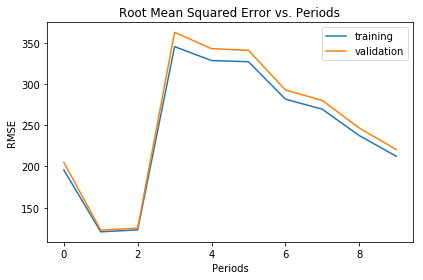

In [7]:
train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [8]:
np.arange(1.0, 7)

array([1., 2., 3., 4., 5., 6.])

In [23]:
def get_quantile_based_boundaries(feature_values, num_buckets):
    boundaries = np.arange(1.0, num_buckets)/num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

households = tf.feature_column.numeric_column("households")
bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries= get_quantile_based_boundaries(california_housing_dataframe["households"],7))
longitude = tf.feature_column.numeric_column("longitude")
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries= get_quantile_based_boundaries(california_housing_dataframe["longitude"],10))    


In [24]:
def construct_feature_columns():
    """Construct the TensorFlow Feature Columns.

    Returns:
    A set of feature columns
    """
    households = tf.feature_column.numeric_column("households")
    longitude = tf.feature_column.numeric_column("longitude")
    latitude = tf.feature_column.numeric_column("latitude")
    housing_median_age = tf.feature_column.numeric_column("housing_median_age")
    median_income = tf.feature_column.numeric_column("median_income")
    rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")

    # Divide households into 7 buckets.
    bucketized_households = tf.feature_column.bucketized_column(
        households, boundaries=get_quantile_based_boundaries(
            training_examples["households"], 7))

    # Divide longitude into 10 buckets.
    bucketized_longitude = tf.feature_column.bucketized_column(
        longitude, boundaries=get_quantile_based_boundaries(
            training_examples["longitude"], 10))

    #
    # YOUR CODE HERE: bucketize the following columns, following the example above:
    #
    bucketized_latitude = bucketized_households = tf.feature_column.bucketized_column(
        latitude, boundaries=get_quantile_based_boundaries(
            training_examples["latitude"], 7))
    bucketized_housing_median_age = bucketized_households = tf.feature_column.bucketized_column(
        housing_median_age, boundaries=get_quantile_based_boundaries(
            training_examples["housing_median_age"], 7))
    bucketized_median_income = bucketized_households = tf.feature_column.bucketized_column(
        median_income, boundaries=get_quantile_based_boundaries(
            training_examples["median_income"], 7))
    bucketized_rooms_per_person = bucketized_households = tf.feature_column.bucketized_column(
        rooms_per_person, boundaries=get_quantile_based_boundaries(
            training_examples["rooms_per_person"], 7))

    long_x_lat = tf.feature_column.crossed_column(
    set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000) 

    feature_columns = set([
        bucketized_longitude,
        bucketized_latitude,
        bucketized_housing_median_age,
        bucketized_households,
        bucketized_median_income,
        bucketized_rooms_per_person])

    return feature_columns

Training model...
RMSE (on training data):
  period 00 : 178.77
  period 01 : 154.58
  period 02 : 138.44
  period 03 : 126.78
  period 04 : 118.00
  period 05 : 111.22
  period 06 : 105.89
  period 07 : 101.45
  period 08 : 97.80
  period 09 : 94.67
Model training finished.


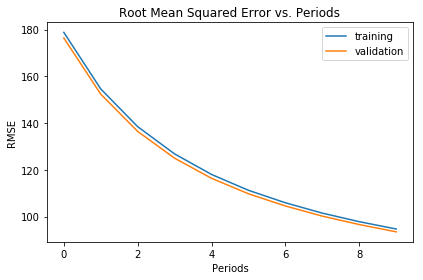

In [25]:
train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)